In [1]:
import pandas as pd

train_df = pd.read_parquet("../data/raw/train.parquet")
test_df = pd.read_parquet("../data/raw/test.parquet")

train_texts = train_df["text"].tolist()
train_labels = train_df["label"].tolist()

test_texts = test_df["text"].tolist()
test_labels = test_df["label"].tolist()

print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")



Train samples: 25000
Test samples: 25000


In [2]:

import re

def basic_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9\s']", " ", text)
    return text.split()

# Build vocab
def build_vocab(texts, max_size=30000, min_freq=2):
    """Build a token vocabulary from raw texts.

    Parameters
    ----------
    texts : Iterable[str]
        Sequence of raw text strings to be tokenized with `basic_tokenize`.
    max_size : int, optional
        Maximum number of tokens in the vocabulary (including special tokens
        "<pad>" and "<unk>"), by default 30000.
    min_freq : int, optional
        Minimum token frequency required for a token to be included, by default 2.

    Returns
    -------
    tuple (stoi, itos)
        itos : list
            Index-to-string list where itos[0] == "<pad>" and itos[1] == "<unk>",
            followed by tokens ordered by descending frequency.
        stoi : dict
            String-to-index mapping corresponding to `itos`.

    Behavior
    --------
    Token frequencies are computed using `basic_tokenize`. Tokens are added
    to the vocabulary in frequency order until either `max_size` is reached
    or tokens fall below `min_freq`.
    """
    from collections import Counter
    counter = Counter()
    for t in texts:
        counter.update(basic_tokenize(t))
    
    itos = ["<pad>", "<unk>"]
    for tok, freq in counter.most_common():
        if freq < min_freq: break
        if len(itos) >= max_size: break
        itos.append(tok)
    stoi = {tok: i for i, tok in enumerate(itos)}
    return stoi, itos

# Encode
def encode(text, stoi, max_len=256):
    toks = basic_tokenize(text)[:max_len]
    ids = [stoi.get(t, 1) for t in toks]  # unk=1
    if len(ids) < max_len:
        ids = ids + [0]*(max_len - len(ids))  # pad=0
    return ids


In [3]:
stoi, itos = build_vocab(train_texts)
len(itos)  # vocab size

30000

In [ ]:
n_tokens_train = [len(basic_tokenize(t)) for t in train_texts]


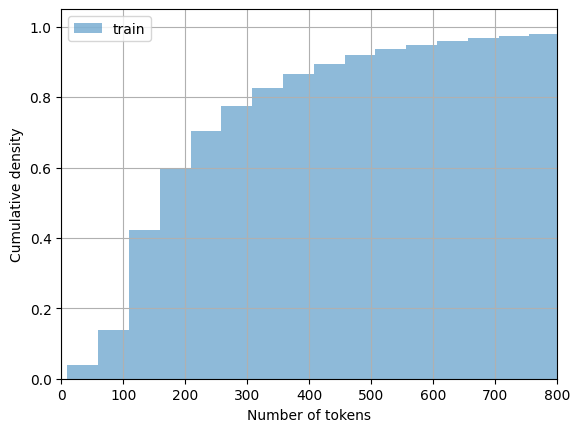

In [12]:
# cumulative histogram of number of tokens
import matplotlib.pyplot as plt

plt.hist(
    n_tokens_train,
    bins=50,
    alpha=0.5,
    label="train",
    density=True,
    cumulative=True,
)
plt.xlabel("Number of tokens")
plt.ylabel("Cumulative density")
plt.legend()
plt.xlim(0, 800)
plt.grid()
plt.show()

The graph shows the distribution of the number of tokens in the training and test datasets. It looks like >90% of reviews have fewer than 512 tokens.

In [14]:
import torch
from torch.utils.data import Dataset

class IMDBParquetDataset(Dataset):
    def __init__(self, texts, labels, stoi, max_len=256):
        self.texts = texts
        self.labels = labels
        self.stoi = stoi
        self.max_len = max_len
        self.encoded = [encode(t, self.stoi, max_len) for t in self.texts]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        X = torch.tensor(self.encoded[idx]).long()
        y = torch.tensor(self.labels[idx]).long()
        return X, y


In [34]:
train_pt = IMDBParquetDataset(train_texts, train_labels, stoi, 512)
test_pt  = IMDBParquetDataset(test_texts, test_labels, stoi, 512)


In [35]:
X, y = train_pt[0]
X.shape, y


(torch.Size([512]), tensor(0))

In [36]:
import torch.nn as nn

class EmbeddingMeanClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, num_classes=2, pad_idx=0):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        self.fc = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len) with token IDs
        emb = self.embed(x)          # (batch_size, seq_len, emb_dim)
        mean_emb = emb.mean(dim=1)   # (batch_size, emb_dim) – average over sequence
        logits = self.fc(mean_emb)   # (batch_size, num_classes)
        return logits


In [41]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = EmbeddingMeanClassifier(len(itos), emb_dim=128).to(device)

model

EmbeddingMeanClassifier(
  (embed): Embedding(30000, 128, padding_idx=0)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)

In [42]:
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader


train_loader = DataLoader(train_pt, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_pt, batch_size=128)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [43]:
from tqdm import tqdm

def evaluate():
    model.eval()
    preds, golds = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            logits = model(X)
            pred = logits.argmax(1)
            preds.extend(pred.cpu().numpy())
            golds.extend(y.cpu().numpy())
    return accuracy_score(golds, preds), f1_score(golds, preds)

for epoch in tqdm(range(7)):
    model.train()
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()

    acc, f1 = evaluate()
    print(f"Epoch {epoch+1}: acc={acc:.4f} f1={f1:.4f}")


 14%|█▍        | 1/7 [00:16<01:41, 16.91s/it]

Epoch 1: acc=0.7764 f1=0.7665


 29%|██▊       | 2/7 [00:33<01:24, 16.93s/it]

Epoch 2: acc=0.8501 f1=0.8498


 43%|████▎     | 3/7 [00:50<01:07, 16.96s/it]

Epoch 3: acc=0.8684 f1=0.8669


 57%|█████▋    | 4/7 [01:09<00:53, 17.68s/it]

Epoch 4: acc=0.8773 f1=0.8764


 71%|███████▏  | 5/7 [01:29<00:37, 18.61s/it]

Epoch 5: acc=0.8828 f1=0.8823


 86%|████████▌ | 6/7 [01:50<00:19, 19.23s/it]

Epoch 6: acc=0.8834 f1=0.8807


100%|██████████| 7/7 [02:10<00:00, 18.66s/it]

Epoch 7: acc=0.8867 f1=0.8854
